In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import skimage.measure

In [2]:
path_root = "/home/arnab/MEGAsync/Research/Attention Tracking/Eye Tracking/Data_Backup/saved_sessions_latest/"

In [3]:
with open("session_track.json", 'r') as f:
    session_track = json.load(f)
session_track

{'template': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': '',
   'Position 2': '',
   'Position 3': '',
   'Position 4': '',
   'Position 5': '',
   'Position 6': '',
   'Position 7': '',
   'Position 8': '',
   'Position 9': '',
   'Right': '',
   'Left': '',
   'Up': '',
   'Down': '',
   'Blink': ''}},
 'P0': {'glass': 0,
  'gender': 'male',
  'brightness': -1,
  'camera_res': {'mega_pixels': 2, 'frame_per_second': 30},
  'sessions': {'Position 1': 'session_2021-09-24T10:09:59.226067.json',
   'Position 2': 'session_2021-09-24T10:10:40.966059.json',
   'Position 3': 'session_2021-09-24T10:11:12.264553.json',
   'Position 4': 'session_2021-09-24T10:11:40.039892.json',
   'Position 5': 'session_2021-09-24T10:12:05.820481.json',
   'Right': 'session_2021-09-24T10:13:07.759221.json',
   'Left': 'session_2021-09-24T10:13:32.368622.json',
   'Up': 'session_2021-09-24T10:13:59.251024.json',
   

In [4]:
def getSecondFromTimeStamp(timestamp):
    return timestamp["hour"]*60*60 + timestamp["minute"]*60 + timestamp["seconds"]


def gaze__processOneSession(gaze_arr, latest = None):
    xrr = []
    yrr = []
    if(latest != None and len(gaze_arr) > 0):
        endtime = getSecondFromTimeStamp(gaze_arr[-1]["timestamp"])
    for gaze in gaze_arr:
        if(latest != None):
            curr_time = getSecondFromTimeStamp(gaze["timestamp"])
            if(endtime - curr_time > latest):
                continue
        xrr.append(gaze["gaze"]["x"])
        yrr.append(gaze["gaze"]["y"])
    return np.array(xrr), np.array(yrr)


def loadjson_singleSession(session_name):
    session_name = session_name.replace(":", "%3a")
    folder = session_name.split('.json')[0]
    with open(path_root + folder + "/" + session_name, 'r') as f:
        session = json.load(f)
        if(len(session.keys()) != 1):
            print("{} session has {} ids".format(session_name, len(session.keys())))
        ret_session = []
        ret_len = 0
        for id in session:
            if(len(session[id]) > ret_len):
                ret_len = len(session[id])
                ret_session = session[id]
        return ret_session


def calculate_MSE(xrr, yrr, marker_x, marker_y):
    ret = 0
    for idx in range(xrr.shape[0]):
        ret += (marker_x - xrr[idx])**2 + (marker_y - yrr[idx])**2
    return ret/xrr.shape[0]

In [5]:
def truncate_array(array, min_val = 0, max_val = 1):
    ret = []
    for val in array:
        v = max(val, min_val)
        v = min(v, max_val)
        ret.append(v)
    return np.array(ret)

In [6]:
not_valid = ["template", "P0", "P0_", "P17"]

def loadjson__multileSession(position_filters, time_limit = 15, _filter = {"glass": -1, "gender": -1, "brightness": -1, "camera_res": -1}):
    combined_xrr = np.array([])
    combined_yrr = np.array([])
    individual_mse = []
    counter = 0

    if(type(position_filters) != list):
        position_filters = [position_filters]
    
    for position_key in position_filters:
        for participant in session_track:
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"])
            if participant in not_valid:
                continue
            # if glass != -1 and session_track[participant]["glass"] != glass:
            #     continue
            skip = False
            for key in _filter:
                if(key != "camera_res"):
                    val = session_track[participant][key]
                else:
                    val = session_track[participant]["camera_res"]["mega_pixels"]
                    if(val == -1):
                        skip = True
                        break
                    val = round(val, 1)
                    
                # print(key, " >> ", _filter[key], " <><> ", val)
                if(_filter[key] != -1 and val != _filter[key]):
                    skip = True
                    break

            if(skip):
                continue
            # print(" >> ", participant, " -- glass:", session_track[participant]["glass"], end=" <> ")
            
            json_session = loadjson_singleSession(session_track[participant]['sessions'][position_key])
            xrr, yrr = gaze__processOneSession(json_session, time_limit)
            xrr = truncate_array(xrr)
            yrr = truncate_array(yrr)
            # print("Shape: ", xrr.shape, yrr.shape)
            if(len(xrr) > 0):
                individual_mse.append(calculate_MSE(xrr, yrr, marker_track[position_key][0], marker_track[position_key][1]))
            else:
                continue
            combined_xrr = np.concatenate((combined_xrr, xrr))
            combined_yrr = np.concatenate((combined_yrr, yrr))
            counter += 1
     
    print("Found {} participants >> Combined shape".format(counter), combined_xrr.shape, combined_yrr.shape)
    return combined_xrr, combined_yrr, individual_mse, counter

In [7]:
session_name = "session_2021-09-24T10:09:59.226067/session_2021-09-24T10:09:59.226067.json"
session_name = session_name.replace(":", "%3a")
with open(path_root + session_name, 'r') as f:
    session = json.load(f)

In [8]:
xrr, yrr = gaze__processOneSession(session['hdehheeafrlqlylodn58si'], 10)
xrr.shape, yrr.shape

((124,), (124,))

In [9]:
accuracy_cords = [
    {'x': 50, 'y': 50},
    {'x': 10, 'y': 10},
    {'x': 10, 'y': 50},
    {'x': 10, 'y': 90},
    {'x': 50, 'y': 10},
    {'x': 50, 'y': 90},
    {'x': 90, 'y': 10},
    {'x': 90, 'y': 50},
    {'x': 90, 'y': 90},
]

marker_track = {}
for i in range(len(accuracy_cords)):
    marker_track["Position {}".format(i+1)] = [accuracy_cords[i]['x']/100, accuracy_cords[i]['y']/100]

print(len(marker_track.keys()))
marker_track

9


{'Position 1': [0.5, 0.5],
 'Position 2': [0.1, 0.1],
 'Position 3': [0.1, 0.5],
 'Position 4': [0.1, 0.9],
 'Position 5': [0.5, 0.1],
 'Position 6': [0.5, 0.9],
 'Position 7': [0.9, 0.1],
 'Position 8': [0.9, 0.5],
 'Position 9': [0.9, 0.9]}

In [10]:
def plotHeatmap(xrr, yrr, subplot):
    heat_map = np.zeros((1001, 1001))
    for idx in range(xrr.shape[0]):
        xx = int(round(xrr[idx]*1000))
        xx = max(xx, 0)
        xx = min(xx, 1000)

        yy = int(round(yrr[idx]*1000))
        yy = max(yy, 0)
        yy = min(yy, 1000)
        try:
            heat_map[yy, xx] += 1
        except:
            print(f"{yy}({yrr[idx]}), {xx}({xrr[idx]})")
            # return
    # print("heatmap shape", heat_map.shape)
    heatmap_reduced = skimage.measure.block_reduce(heat_map, (100,100), np.mean)
    # print(heatmap_reduced.shape, heatmap_reduced.min(), heatmap_reduced.max())
    subplot.pcolormesh(np.arange(11), np.arange(11), heatmap_reduced, 
                    shading='gouraud', 
                    vmin=heatmap_reduced.min(), 
                    vmax=heatmap_reduced.max())
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.invert_yaxis()

In [11]:
position = "Position 9"
xrr, yrr, ind_mse, counter = loadjson__multileSession(position)

session_2021-10-02T10%3a16%3a34.642542.json session has 2 ids
session_2021-10-04T02%3a40%3a07.729511.json session has 2 ids
Found 31 participants >> Combined shape (6184,) (6184,)


/home/arnab/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


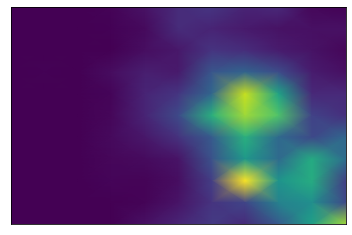

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plotHeatmap(xrr, yrr, ax)
fig.show()

In [13]:
def check_cohesiveness(xrr, yrr):
    diff_x = xrr.mean() - xrr
    diff_y = yrr.mean() - yrr
    sum_dist = 0
    for x,y in zip(diff_x, diff_y):
        sum_dist += x*x + y*y
    mean_dist = sum_dist/xrr.shape[0]

    return mean_dist

In [14]:
def merge_gaze_points(xrr1, yrr1, xrr2, yrr2):
    xrr = np.concatenate((xrr1, xrr2))
    yrr = np.concatenate((yrr1, yrr2))

    order = np.arange(xrr.shape[0])
    np.random.shuffle(order)
    ret_x = []
    ret_y = []
    for o in order:
        ret_x.append(xrr[o])
        ret_y.append(yrr[o])
    
    return np.array(ret_x), np.array(ret_y)

In [15]:
def getCompareFig(xrr_lft, yrr_lft, xrr_rgt, yrr_rgt):
    plt.rcParams["figure.figsize"] = (10, 4)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plotHeatmap(xrr_lft, yrr_lft, ax[0])
    plotHeatmap(xrr_rgt, yrr_rgt, ax[1])

    return fig

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
# from yellowbrick.cluster import KElbowVisualizer
import json
import pandas as pd
import numpy as np
import seaborn as sns
import math
import skimage.measure
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import os
import random

In [17]:
def point_dist(x1, y1, x2, y2):
    return np.math.sqrt((x2-x1)**2 + (y2-y1)**2)

def getClusterCentroid(points_df):
    return tuple(points_df.mean())

def getIntraClusterDistance(points_df, times=1000):
    sum = 0
    for idx, ipt in points_df.iterrows():
        x1 = ipt["x0"]*times
        y1 = ipt["x1"]*times
        for jdx, jpt in points_df.iterrows():
            x2 = jpt["x0"]*times
            y2 = jpt["x1"]*times
        sum += point_dist(x1, y1, x2, y2)

    intra_dist_times_1000 = sum/(len(points_df)**2)
    return intra_dist_times_1000

def getSingleCluster__attrs(points_df):
    return {
        "num points": len(points_df),
        "center"    : getClusterCentroid(points_df),
        # "intra_dist": getIntraClusterDistance(points_df, times=1000)
        "intra_dist": 'X'
    }


In [18]:
position = "Position 3"

min_val = 0
max_val = 1


print(f"Loading Data of {position} ... ")
xrr, yrr, ind_mse, counter = loadjson__multileSession(position)
print("Loaded data --- ", xrr.shape)

Loading Data of Position 3 ... 
session_2021-10-02T05%3a09%3a58.567128.json session has 0 ids
session_2021-10-04T02%3a37%3a28.882140.json session has 2 ids
Found 30 participants >> Combined shape (5722,) (5722,)
Loaded data ---  (5722,)


Generating Random Sample
(5000, 33) (5000, 33)
Knee >> 4373 -- 0.05175911570856935
Number of clusters:  0
-1 >> number of points: 5000; center: (0.5050267095500183, 0.4979306814574108); intra_cluster_dist: X
>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<
Loading Data of Position 1 ... 
session_2021-10-04T02%3a35%3a57.883970.json session has 2 ids
session_2021-10-05T00%3a42%3a54.533873.json session has 0 ids
session_2021-10-05T08%3a35%3a35.317479.json session has 2 ids
Found 30 participants >> Combined shape (6610,) (6610,)
Loaded data ---  (6610,)
(6610, 33) (6610, 33)
Knee >> 5690 -- 0.05080354318352218
Number of clusters:  1
-1 >> number of points: 1639; center: (0.637180597925564, 0.4145485051860888); intra_cluster_dist: X
 0 >> number of points: 4971; center: (0.502776503721586, 0.530424260712131); intra_cluster_dist: X
>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<
Loading Data of Position 2 ... 
session_2021-10-02T09%3a45%3a34.906832.json session has 2 ids
session_2021-10-02T10%3a11%3a51.061924.json s

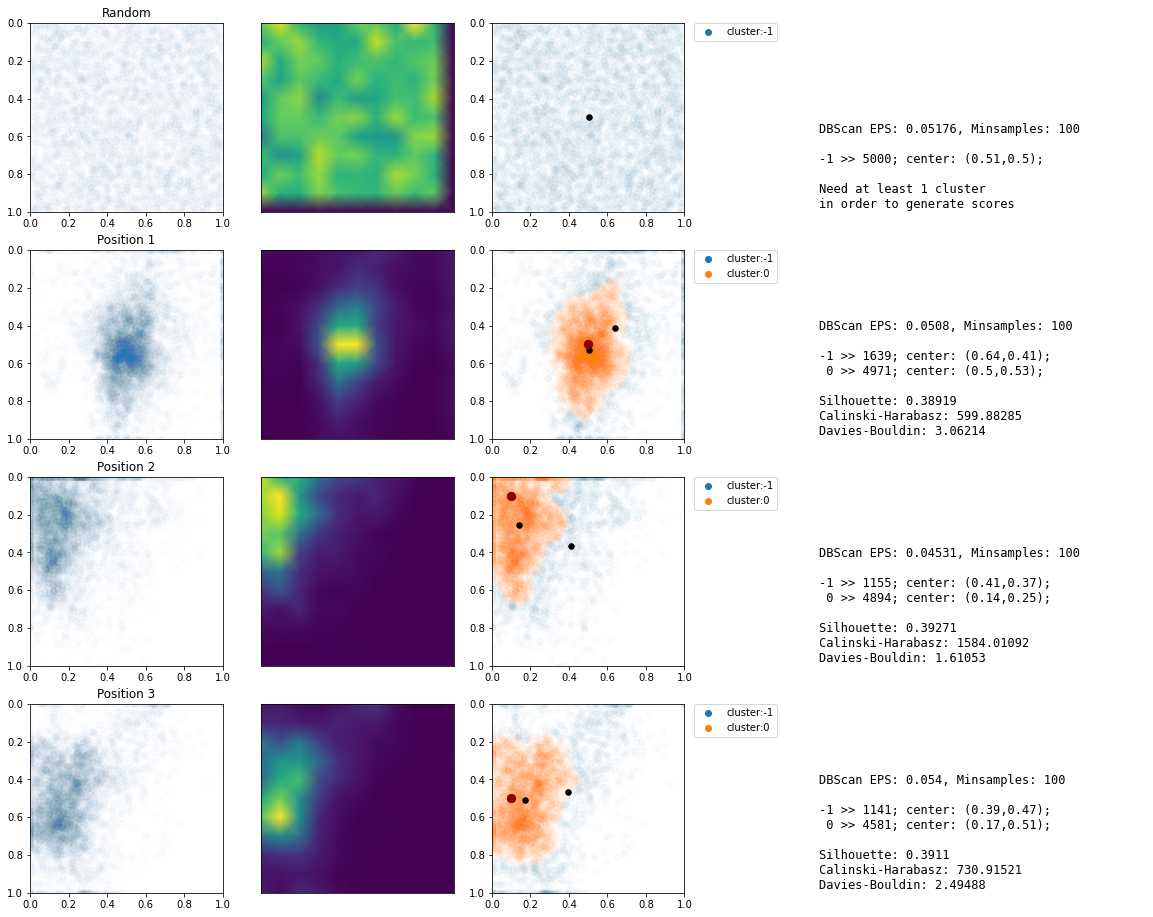

In [40]:
#######################################################################
limiter = 4
positions = ['rand'] + list(marker_track.keys())
min_samples = 100
######################################################################

col_fix = 5
col_width = 20

plt.rcParams["figure.figsize"] = (col_width, min(limiter, len(positions))*col_width/col_fix)
fig, ax = plt.subplots(nrows=min(len(positions), limiter), ncols=col_fix)


for idx in range(min(len(positions), limiter)):
    position = positions[idx]

    if(position == "rand"):
        print("Generating Random Sample")
        xrr = np.random.uniform(0, 1, 5000)
        yrr = np.random.uniform(0, 1, 5000)

    else:
        print(f"Loading Data of {position} ... ")
        xrr, yrr, _, _ = loadjson__multileSession(position)
        print("Loaded data --- ", xrr.shape)

    analysis_row = idx

    ##################################################################

    col = 0
    ax[analysis_row, col].scatter(xrr, yrr, alpha = 0.01)
    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    ax[analysis_row, col].invert_yaxis()
    if(position == "rand"):
        sub_title = "Random"
    else:
        sub_title = position
    ax[analysis_row, col].title.set_text(f"{sub_title}")
    col += 1
    ###################################################################
    plotHeatmap(xrr, yrr, ax[analysis_row, col])
    col += 1
    # ###################################################################
    X = np.array([xrr, yrr]).T

    nearest_neighbors = NearestNeighbors(n_neighbors=min_samples//3)
    neighbors = nearest_neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    print(distances.shape, indices.shape)
    dist = np.sort(distances[:,-1])
    i = np.arange(len(dist))
    kneedle = KneeLocator(
                i, dist, S=1, 
                curve='convex', 
                direction='increasing', 
                interp_method='polynomial'
            )
    knee_val = dist[kneedle.knee]

    print(f"Knee >> {kneedle.knee} -- {knee_val}")

    ###################################################################
    description = f"DBScan EPS: {round(knee_val, 5)}, Minsamples: {min_samples}\n\n"
    model = DBSCAN(eps=knee_val, min_samples=min_samples).fit(X)
    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Number of clusters: ", n_clusters_)

    df = pd.DataFrame({
        "x0"    : X[:, 0],
        "x1"    : X[:, 1],
        "pred_y": labels
    })
    centroids = []

    for cluster in range(-1, n_clusters_):
        points_df = df[df["pred_y"] == cluster][["x0", "x1"]]
        single_cluster_attrs = getSingleCluster__attrs(points_df)
        cluster_name = "-1"
        if(cluster != -1):
            cluster_name = " {}".format(cluster)
        print("{} >> number of points: {}; center: {}; intra_cluster_dist: {}".format(
            cluster_name, len(points_df), single_cluster_attrs["center"] ,single_cluster_attrs["intra_dist"]))
        description += "{} >> {}; center: ({},{});\n".format(
            cluster_name, len(points_df), round(single_cluster_attrs["center"][0], 2), 
            round(single_cluster_attrs["center"][1],2))

        centroids.append(single_cluster_attrs["center"])
        ax[analysis_row, col].scatter(points_df["x0"], points_df["x1"], label = "cluster:{}".format(cluster), alpha = .02)

    for center in centroids:
        ax[analysis_row, col].scatter(center[0] , center[1] , s = 30, color = 'k')

    if(position != 'rand'):
        marker = marker_track[position]
        ax[analysis_row, col].scatter(marker[0] , marker[1] , s = 70, color = 'darkred')

    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    leg = ax[analysis_row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[analysis_row, col].invert_yaxis()
    col += 1

    ax[analysis_row, col].axis('off')
    col += 1
    ####################################################################

    if(n_clusters_ > 0):
        description += "\n"
        description += "\n".join([
            f"Silhouette: {round(silhouette_score(X, labels), 5)}",
            f"Calinski-Harabasz: {round(calinski_harabasz_score(X, labels), 5)}",
            f"Davies-Bouldin: {round(davies_bouldin_score(X, labels), 5)}"
        ])
    else:
        description += "\nNeed at least 1 cluster\nin order to generate scores"

    ax[analysis_row, col].set_xlim([0, 1])
    ax[analysis_row, col].set_ylim([0, 1])
    ax[analysis_row, col].text(-0.7,0.02, description, family="monospace", fontsize=12)
    ax[analysis_row, col].axis('off')

    print(">>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<")
    counter += 1

    # break

In [34]:
marker_track.keys()

dict_keys(['Position 1', 'Position 2', 'Position 3', 'Position 4', 'Position 5', 'Position 6', 'Position 7', 'Position 8', 'Position 9'])

Generating DBScan Analysis for  ('Position 1', 'Position 2')
Loading Data of Position 1 ... 
session_2021-10-04T02%3a35%3a57.883970.json session has 2 ids
session_2021-10-05T00%3a42%3a54.533873.json session has 0 ids
session_2021-10-05T08%3a35%3a35.317479.json session has 2 ids
Found 30 participants >> Combined shape (6610,) (6610,)
Loading Data of Position 2 ... 
session_2021-10-02T09%3a45%3a34.906832.json session has 2 ids
session_2021-10-02T10%3a11%3a51.061924.json session has 2 ids
session_2021-10-04T02%3a36%3a38.093949.json session has 2 ids
session_2021-10-05T08%3a56%3a54.162246.json session has 2 ids
Found 31 participants >> Combined shape (6049,) (6049,)
Loaded data ---  (12659,)
(12659, 33) (12659, 33)
Knee >> 11030 -- 0.035999999999999976
Number of clusters:  3
-1 >> number of points: 4252; center: (0.48668861712135497, 0.41328927563499457); intra_cluster_dist: X
 0 >> number of points: 4254; center: (0.4979280677009882, 0.532623883403856); intra_cluster_dist: X
 1 >> number 

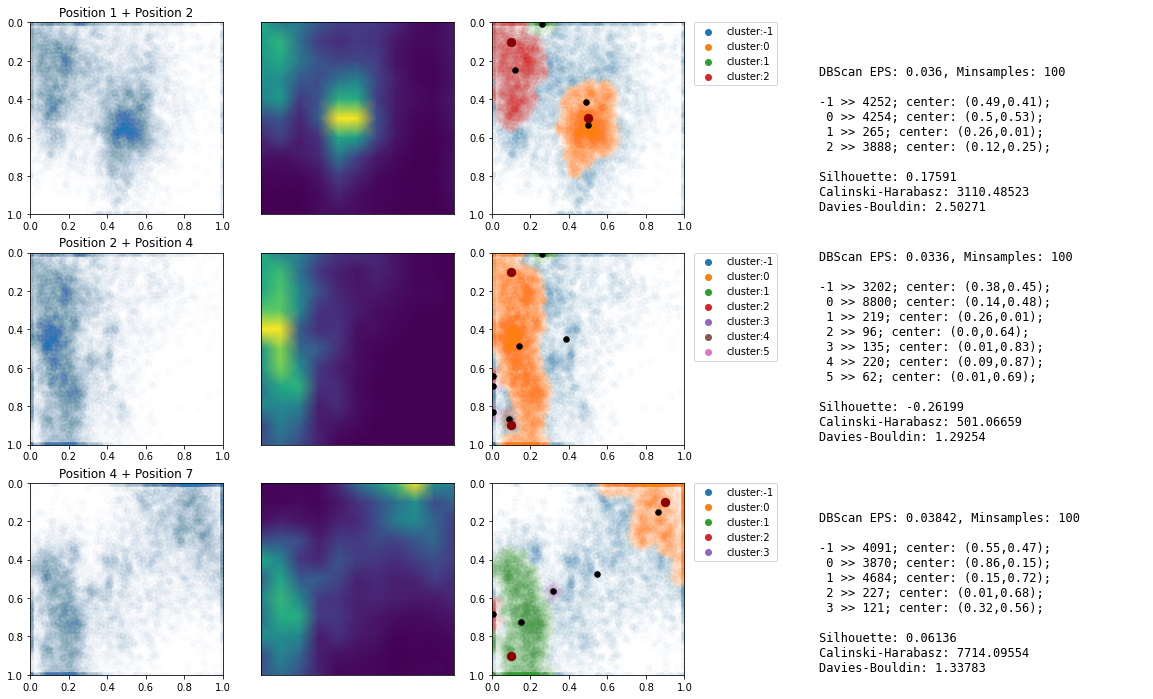

In [44]:
#######################################################################
limiter = 4
positions = ['rand'] + list(marker_track.keys())
min_samples = 100
combinations = [
    ('Position 1', 'Position 2'), 
    ('Position 2', 'Position 4'), 
    ('Position 4', 'Position 7')
]
######################################################################

col_fix = 5
col_width = 20

plt.rcParams["figure.figsize"] = (col_width, min(limiter, len(combinations))*col_width/col_fix)
fig, ax = plt.subplots(nrows=min(len(combinations), limiter), ncols=col_fix)


for comb_idx in range(min(len(combinations), limiter)):
    comb = combinations[comb_idx]

    print("Generating DBScan Analysis for ", comb)
    xrr = np.array([])
    yrr = np.array([])
    for position in comb:
        print(f"Loading Data of {position} ... ")
        cur_xrr, cur_yrr, _, _ = loadjson__multileSession(position)
        xrr = np.concatenate((xrr, cur_xrr))
        yrr = np.concatenate((yrr, cur_yrr))
    print("Loaded data --- ", xrr.shape)

    analysis_row = comb_idx

    ##################################################################

    col = 0
    ax[analysis_row, col].scatter(xrr, yrr, alpha = 0.01)
    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    ax[analysis_row, col].invert_yaxis()
    ax[analysis_row, col].title.set_text(" + ".join(comb))
    col += 1
    ###################################################################
    plotHeatmap(xrr, yrr, ax[analysis_row, col])
    col += 1
    # ###################################################################
    X = np.array([xrr, yrr]).T

    nearest_neighbors = NearestNeighbors(n_neighbors=min_samples//3)
    neighbors = nearest_neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    print(distances.shape, indices.shape)
    dist = np.sort(distances[:,-1])
    i = np.arange(len(dist))
    kneedle = KneeLocator(
                i, dist, S=1, 
                curve='convex', 
                direction='increasing', 
                interp_method='polynomial'
            )
    knee_val = dist[kneedle.knee]

    print(f"Knee >> {kneedle.knee} -- {knee_val}")

    ###################################################################
    description = f"DBScan EPS: {round(knee_val, 5)}, Minsamples: {min_samples}\n\n"
    model = DBSCAN(eps=knee_val, min_samples=min_samples).fit(X)
    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Number of clusters: ", n_clusters_)

    df = pd.DataFrame({
        "x0"    : X[:, 0],
        "x1"    : X[:, 1],
        "pred_y": labels
    })
    centroids = []

    for cluster in range(-1, n_clusters_):
        points_df = df[df["pred_y"] == cluster][["x0", "x1"]]
        single_cluster_attrs = getSingleCluster__attrs(points_df)
        cluster_name = "-1"
        if(cluster != -1):
            cluster_name = " {}".format(cluster)
        print("{} >> number of points: {}; center: {}; intra_cluster_dist: {}".format(
            cluster_name, len(points_df), single_cluster_attrs["center"] ,single_cluster_attrs["intra_dist"]))
        description += "{} >> {}; center: ({},{});\n".format(
            cluster_name, len(points_df), round(single_cluster_attrs["center"][0], 2), 
            round(single_cluster_attrs["center"][1],2))

        centroids.append(single_cluster_attrs["center"])
        ax[analysis_row, col].scatter(points_df["x0"], points_df["x1"], label = "cluster:{}".format(cluster), alpha = .02)

    for center in centroids:
        ax[analysis_row, col].scatter(center[0] , center[1] , s = 30, color = 'k')

    for position in comb:
        marker = marker_track[position]
        ax[analysis_row, col].scatter(marker[0] , marker[1] , s = 70, color = 'darkred')

    ax[analysis_row, col].set_xlim([0,1])
    ax[analysis_row, col].set_ylim([0,1])
    leg = ax[analysis_row, col].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax[analysis_row, col].invert_yaxis()
    col += 1

    ax[analysis_row, col].axis('off')
    col += 1
    ####################################################################

    if(n_clusters_ > 0):
        description += "\n"
        description += "\n".join([
            f"Silhouette: {round(silhouette_score(X, labels), 5)}",
            f"Calinski-Harabasz: {round(calinski_harabasz_score(X, labels), 5)}",
            f"Davies-Bouldin: {round(davies_bouldin_score(X, labels), 5)}"
        ])
    else:
        description += "\nNeed at least 1 cluster\nin order to generate scores"

    ax[analysis_row, col].set_xlim([0, 1])
    ax[analysis_row, col].set_ylim([0, 1])
    ax[analysis_row, col].text(-0.7,0.02, description, family="monospace", fontsize=12)
    ax[analysis_row, col].axis('off')

    print(">>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<")
    counter += 1

    # break